In [1]:
!pip install torchtext==0.18.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 27.8 MB/s eta 0:00:00


In [2]:
!pip install torch==2.3.0 torchvision==0.18.0 torchaudio==2.3.0 --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.9/780.9 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 103.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 88.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 95.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 43.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 51.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 799.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/19

In [3]:
import torch
import pandas as pd
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer
import random
import time
import torch.nn.functional as F

/usr/local/lib/python3.12/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.12/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.12/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated

In [4]:
RANDOM_SEED=42
torch.manual_seed(RANDOM_SEED)

RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)

NUM_EPOCHS = 25
BATCH_SIZE = 64
LEARNING_RATE = 3e-4

EMBEDDING_DIM = 128
FFN_DIM = 256
NUM_HEADS = 4
NUM_LAYERS = 2

VOCAB_SIZE = 20000
MAX_LEN = 256

torch.backends.cudnn.deterministic = True

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


In [5]:
tokenizer=get_tokenizer('spacy',language='en_core_web_sm')

In [6]:
def yeild_tokens(data_iter):
    for _,text in data_iter:
        yield tokenizer(text)

In [7]:
class IMDBCSVDataset(Dataset):
    def __init__(self,csv):
        self.data=pd.read_csv(csv)
        self.data['sentiment']=self.data['sentiment'].map({'positive':1,'negative':0})

    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):
        label=self.data.iloc[idx]['sentiment']
        text=self.data.iloc[idx]['review']
        return label,text

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
dataset=IMDBCSVDataset('/content/drive/My Drive/IMDB_sentiment_analysis/IMDB Dataset.csv')
train_dataset,test_dataset=torch.utils.data.random_split(dataset,[0.8,0.2])
train_dataset,val_dataset=torch.utils.data.random_split(train_dataset,[0.85,0.15])

print(f'Length of train dataset: {len(train_dataset)}')
print(f'Length of val dataset: {len(val_dataset)}')
print(f'Length of test dataset: {len(test_dataset)}')

Length of train dataset: 34000
Length of val dataset: 6000
Length of test dataset: 10000


In [10]:
vocab=build_vocab_from_iterator(yeild_tokens(train_dataset),max_tokens=VOCAB_SIZE,specials=['<unk>','<pad>'])
vocab.set_default_index(vocab['<unk>'])

In [11]:
def text_pipeline(x):
    tokens=tokenizer(x)
    indexed_token=[vocab[token] for token in tokens]
    return torch.tensor(indexed_token,dtype=torch.long)

In [12]:
def collate_fn(batch):
    labels,texts=[],[]
    for label,text in batch:
        labels.append(label)
        processed_text=text_pipeline(text)
        texts.append(processed_text)
    labels=torch.tensor(labels,dtype=torch.float)
    texts=pad_sequence(texts,batch_first=True,padding_value=vocab['<pad>'])
    return labels,texts

In [13]:
train_loader=DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True,collate_fn=collate_fn)
val_loader=DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=False,collate_fn=collate_fn)
test_loader=DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=False,collate_fn=collate_fn)

In [14]:
import math
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

In [15]:
class TransformerSentimentClassifier(nn.Module):
    def __init__(
        self,
        vocab_size,
        embed_dim,
        num_heads,
        num_layers,
        ffn_dim,
        pad_idx,
        dropout=0.1
    ):
        super().__init__()

        self.embedding = nn.Embedding(
            vocab_size, embed_dim, padding_idx=pad_idx
        )
        self.positional_encoding = PositionalEncoding(embed_dim)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=ffn_dim,
            # dropout=dropout,
            batch_first=True
        )

        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.fc = nn.Linear(embed_dim, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        # text: [B, T]
        padding_mask = (text == PAD_IDX)

        x = self.embedding(text)
        x = self.positional_encoding(x)
        x = self.dropout(x)

        encoded = self.encoder(
            x, src_key_padding_mask=padding_mask
        )

        cls_rep = encoded[:, 0, :]  # CLS token
        logits = self.fc(cls_rep).squeeze(1)

        return logits


In [16]:
PAD_IDX = vocab['<pad>']
CLS_IDX = vocab['<cls>']
model = TransformerSentimentClassifier(
    vocab_size=len(vocab),
    embed_dim=EMBEDDING_DIM,
    num_heads=NUM_HEADS,
    num_layers=NUM_LAYERS,
    ffn_dim=FFN_DIM,
    pad_idx=PAD_IDX
).to(DEVICE)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE
)


In [17]:
def compute_accuracy(model, data_loader):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for labels, texts in data_loader:
            labels = labels.to(DEVICE)
            texts = texts.to(DEVICE)

            logits = model(texts)          # ✅ only ONE output
            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).long()

            correct += (preds == labels.long()).sum().item()
            total += labels.size(0)

    return correct / total


In [18]:
from sklearn.metrics import f1_score,recall_score,precision_score,accuracy_score,auc,roc_auc_score

import torch
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)

In [19]:
train_acc=[]
val_acc=[]
patience=5
for e in range(NUM_EPOCHS):
    model.train()
    total_loss = 0
    for labels, texts in train_loader:
        labels = labels.to(DEVICE)
        texts = texts.to(DEVICE)

        optimizer.zero_grad()
        logits = model(texts)
        loss = criterion(logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()
    train_acc.append(compute_accuracy(model,train_loader))
    val_acc.append(compute_accuracy(model,val_loader))
    if e>0:
        if val_acc[-1]<val_acc[-2]:
            patience-=1
        else:
            patience=5
            torch.save(model.state_dict(), 'best_model.pt')
        if patience==0:
            break
    print(f"Epoch {e+1}/{NUM_EPOCHS} | Train Loss: {total_loss} | Train Acc: {train_acc[-1]} | Val Acc: {val_acc[-1]}")


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:408: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)


Epoch 1/25 | Train Loss: 305.4531926214695 | Train Acc: 0.7871176470588235 | Val Acc: 0.7801666666666667
Epoch 2/25 | Train Loss: 218.88055624067783 | Train Acc: 0.852764705882353 | Val Acc: 0.8385
Epoch 3/25 | Train Loss: 187.98335301876068 | Train Acc: 0.8737058823529412 | Val Acc: 0.8496666666666667
Epoch 4/25 | Train Loss: 165.20216600596905 | Train Acc: 0.9007352941176471 | Val Acc: 0.8711666666666666
Epoch 5/25 | Train Loss: 151.52395985275507 | Train Acc: 0.9136470588235294 | Val Acc: 0.8731666666666666
Epoch 6/25 | Train Loss: 136.66854435950518 | Train Acc: 0.9227647058823529 | Val Acc: 0.8728333333333333
Epoch 7/25 | Train Loss: 127.29925799369812 | Train Acc: 0.9362647058823529 | Val Acc: 0.8771666666666667
Epoch 8/25 | Train Loss: 118.46556509286165 | Train Acc: 0.9436176470588236 | Val Acc: 0.8806666666666667
Epoch 9/25 | Train Loss: 107.99075493961573 | Train Acc: 0.9528823529411765 | Val Acc: 0.8846666666666667
Epoch 10/25 | Train Loss: 97.68482049182057 | Train Acc: 0.9

In [20]:
y_pred=[]
y_true=[]
y_prob=[]
model.eval()
for labels, texts in test_loader:
    labels = labels.to(DEVICE)
    texts = texts.to(DEVICE)
    logits = model(texts)
    probs = torch.sigmoid(logits)
    preds = (probs >= 0.5).long()
    y_pred.extend(preds.cpu().numpy())
    y_true.extend(labels.cpu().numpy())
    y_prob.extend(probs.cpu().detach().numpy())

y_pred = np.array(y_pred)
y_true = np.array(y_true)
y_prob = np.array(y_prob)
accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall    = recall_score(y_true, y_pred)
f1        = f1_score(y_true, y_pred)
roc_auc   = roc_auc_score(y_true, y_prob)

print(f"Accuracy  : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1-score  : {f1:.4f}")
print(f"ROC-AUC   : {roc_auc:.4f}")


Accuracy  : 0.8789
Precision : 0.8775
Recall    : 0.8829
F1-score  : 0.8802
ROC-AUC   : 0.9470


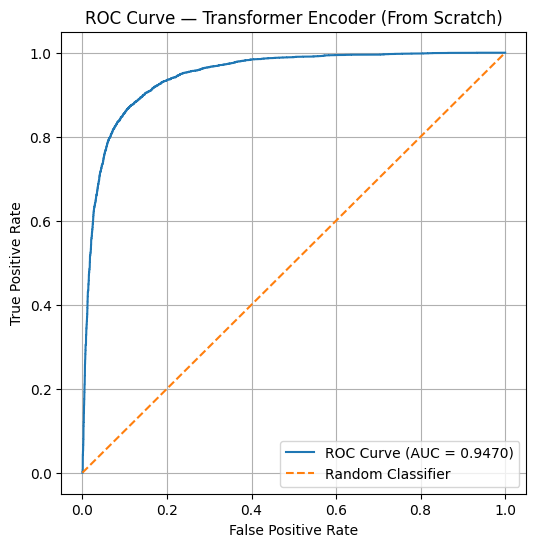

In [22]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
import matplotlib.pyplot as plt
roc_auc = roc_auc_score(y_true, y_prob)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve — Transformer Encoder (From Scratch)')
plt.legend()
plt.grid(True)
plt.show()